<a href="https://colab.research.google.com/github/gnitnaw/LDL/blob/main/stand_alone/aFe1_2level_learning_mnist_matmul.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
The MIT License (MIT)
Copyright (c) 2021 NVIDIA
Permission is hereby granted, free of charge, to any person obtaining a copy of
this software and associated documentation files (the "Software"), to deal in
the Software without restriction, including without limitation the rights to
use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
the Software, and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:
The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
"""


'\nThe MIT License (MIT)\nCopyright (c) 2021 NVIDIA\nPermission is hereby granted, free of charge, to any person obtaining a copy of\nthis software and associated documentation files (the "Software"), to deal in\nthe Software without restriction, including without limitation the rights to\nuse, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of\nthe Software, and to permit persons to whom the Software is furnished to do so,\nsubject to the following conditions:\nThe above copyright notice and this permission notice shall be included in all\ncopies or substantial portions of the Software.\nTHE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR\nIMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS\nFOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR\nCOPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER\nIN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OU

This code example demonstrates how to create a matrix implementation of c4e2_2level_learning_mnist. More context for this code example can be found in the section "Single matrix" in Appendix F in the book Learning Deep Learning by Magnus Ekman (ISBN: 9780137470358).


The first piece of code code is identical to the implementation in c4e2_2level_learning_mnist.

In [2]:
! pip3 install idx2numpy
from google.colab import drive
drive.mount('/content/drive')
path_head = '/content/drive/MyDrive/Colab Notebooks/' # You have to change this. 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7917 sha256=00a2199144a0d23dcee4815893d42403aa4945c9a89bd3d8c25f297fc66cd589
  Stored in directory: /root/.cache/pip/wheels/1a/ce/ad/d5e95a35cfe34149aade5e500f2edd535c0566d79e9a8e1d8a
Successfully built idx2numpy
Mounted at /content/drive


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import idx2numpy

np.random.seed(7) # To make repeatable
LEARNING_RATE = 0.01
EPOCHS = 20
TRAIN_IMAGE_FILENAME = path_head+'data/mnist/train-images-idx3-ubyte'
TRAIN_LABEL_FILENAME = path_head+'data/mnist/train-labels-idx1-ubyte'
TEST_IMAGE_FILENAME = path_head+'data/mnist/t10k-images-idx3-ubyte'
TEST_LABEL_FILENAME = path_head+'data/mnist/t10k-labels-idx1-ubyte'

# Function to read dataset.
def read_mnist():
    train_images = idx2numpy.convert_from_file(
        TRAIN_IMAGE_FILENAME)
    train_labels = idx2numpy.convert_from_file(
        TRAIN_LABEL_FILENAME)
    test_images = idx2numpy.convert_from_file(
        TEST_IMAGE_FILENAME)
    test_labels = idx2numpy.convert_from_file(
        TEST_LABEL_FILENAME)

    # Reformat and standardize.
    x_train = train_images.reshape(60000, 784)
    mean = np.mean(x_train)
    stddev = np.std(x_train)
    x_train = (x_train - mean) / stddev
    x_test = test_images.reshape(10000, 784)
    x_test = (x_test - mean) / stddev

    # One-hot encoded output.
    y_train = np.zeros((60000, 10))
    y_test = np.zeros((10000, 10))
    for i, y in enumerate(train_labels):
        y_train[i][y] = 1
    for i, y in enumerate(test_labels):
        y_test[i][y] = 1
    return x_train, y_train, x_test, y_test

# Read train and test examples.
x_train, y_train, x_test, y_test = read_mnist()
index_list = list(range(len(x_train))) # Used for random order

def layer_w(neuron_count, input_count):
    weights = np.zeros((neuron_count, input_count+1))
    for i in range(neuron_count):
        for j in range(1, (input_count+1)):
            weights[i][j] = np.random.uniform(-0.1, 0.1)
    return weights

# Declare matrices and vectors representing the neurons.
hidden_layer_w = layer_w(25, 784)
hidden_layer_y = np.zeros(25)
hidden_layer_error = np.zeros(25)

output_layer_w = layer_w(10, 25)
output_layer_y = np.zeros(10)
output_layer_error = np.zeros(10)

chart_x = []
chart_y_train = []
chart_y_test = []
def show_learning(epoch_no, train_acc, test_acc):
    global chart_x
    global chart_y_train
    global chart_y_test
    print('epoch no:', epoch_no, ', train_acc: ',
          '%6.4f' % train_acc,
          ', test_acc: ', '%6.4f' % test_acc)
    chart_x.append(epoch_no + 1)
    chart_y_train.append(1.0 - train_acc)
    chart_y_test.append(1.0 - test_acc)

def plot_learning():
    plt.plot(chart_x, chart_y_train, 'r-',
             label='training error')
    plt.plot(chart_x, chart_y_test, 'b-',
             label='test error')
    plt.axis([0, len(chart_x), 0.0, 1.0])
    plt.xlabel('training epochs')
    plt.ylabel('error')
    plt.legend()
    plt.show()


The functions that have changed compared to c4e2_2level_learning_mnist are forward_pass, backward_pass, and adjust_weights. In these functions, we no longer loop over the individual neurons and do dot products, but instead, we handle an entire layer in parallel using matrix operations.

The forward_pass function is straightforward. We use the NumPy matmul function to multiply the weight matrix by the input vector and then apply the activation function tanh on the resulting output vector. We then append a bias needed for the output layer using the concatenate function and do the matrix multiplication and activation function for the output layer as well.

The backward_pass function is not much more complicated. We compute the derivatives of the error function and the activation function but note that all these computations are done on vectors (i.e., all neurons in parallel). Another thing to note is that the mathematical operators +, -, and * are elementwise operators. That is, there is a big difference between using * and the matmul function. One thing to note is the call to np.matrix.transpose and the indexing we do with output_layer_w[:, 1:]. The transpose operation is needed to make the dimensions of the weight matrix match what is needed for a matrix multiplication with the error vector. The indexing is done to get rid of the bias weights when computing the error terms for the hidden neurons because the bias weight from the output layer is not needed for that operation.

The adjust_weights function is slightly tricky. For each of the two layers, we need to create a matrix with the same dimensions as the weight matrix for that layer but where the elements represent the delta to subtract from the weights. The elements of this delta matrix are obtained by multiplying the input value that feeds into a weight by the error term for the neuron that the weight connects to and finally multiplying by the learning rate. We already have the error terms arranged in the vectors hidden_layer_error and output_layer_error. Similarly, we have the input values for the two layers arranged in the vectors x and hidden_layer_y. For each layer we now combine the input vector with the error vector using the function np.outer which computes the outer product of the two vectors. It results in a matrix where the elements are all the pairwise products from the elements in the two vectors, which is exactly what we want. We multiply the matrix by the learning rate and then subtract from the weight matrix.


In [4]:
def forward_pass(x):
    global hidden_layer_y
    global output_layer_y
    # Activation function for hidden layer.
    hidden_layer_z = np.matmul(hidden_layer_w, x)
    hidden_layer_y = np.tanh(hidden_layer_z)
    hidden_output_array = np.concatenate(
        (np.array([1.0]), hidden_layer_y))
    # Activation function for output layer.
    output_layer_z = np.matmul(output_layer_w,
        hidden_output_array)
    output_layer_y = 1.0 / (1.0 + np.exp(-output_layer_z))

def backward_pass(y_truth):
    global hidden_layer_error
    global output_layer_error
    # Backpropagate error for each output neuron.
    error_prime = -(y_truth - output_layer_y)
    output_log_prime = output_layer_y * (
        1.0 - output_layer_y)
    output_layer_error = error_prime * output_log_prime
    # Backpropagate error for each hidden neuron.
    hidden_tanh_prime = 1.0 - hidden_layer_y**2
    hidden_weighted_error = np.matmul(np.matrix.transpose(
        output_layer_w[:, 1:]), output_layer_error)
    hidden_layer_error = (
        hidden_tanh_prime * hidden_weighted_error)

def adjust_weights(x):
    global output_layer_w
    global hidden_layer_w
    delta_matrix = np.outer(
        hidden_layer_error, x) * LEARNING_RATE
    hidden_layer_w -= delta_matrix
    hidden_output_array = np.concatenate(
        (np.array([1.0]), hidden_layer_y))
    delta_matrix = np.outer(
        output_layer_error,
        hidden_output_array) * LEARNING_RATE
    output_layer_w -= delta_matrix


The network training loop is unchanged compared to c4e2_2level_learning_mnist.


epoch no: 0 , train_acc:  0.8563 , test_acc:  0.9157
epoch no: 1 , train_acc:  0.9203 , test_acc:  0.9240
epoch no: 2 , train_acc:  0.9274 , test_acc:  0.9275
epoch no: 3 , train_acc:  0.9335 , test_acc:  0.9288
epoch no: 4 , train_acc:  0.9352 , test_acc:  0.9289
epoch no: 5 , train_acc:  0.9376 , test_acc:  0.9330
epoch no: 6 , train_acc:  0.9402 , test_acc:  0.9350
epoch no: 7 , train_acc:  0.9418 , test_acc:  0.9374
epoch no: 8 , train_acc:  0.9433 , test_acc:  0.9338
epoch no: 9 , train_acc:  0.9449 , test_acc:  0.9347
epoch no: 10 , train_acc:  0.9461 , test_acc:  0.9372
epoch no: 11 , train_acc:  0.9469 , test_acc:  0.9378
epoch no: 12 , train_acc:  0.9485 , test_acc:  0.9377
epoch no: 13 , train_acc:  0.9495 , test_acc:  0.9375
epoch no: 14 , train_acc:  0.9503 , test_acc:  0.9402
epoch no: 15 , train_acc:  0.9505 , test_acc:  0.9355
epoch no: 16 , train_acc:  0.9513 , test_acc:  0.9405
epoch no: 17 , train_acc:  0.9527 , test_acc:  0.9394
epoch no: 18 , train_acc:  0.9522 , te

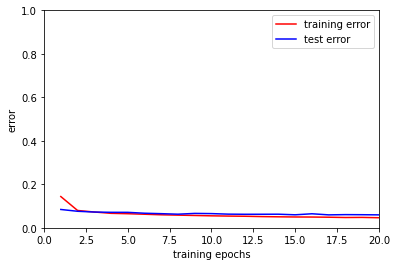

In [5]:
# Network training loop.
for i in range(EPOCHS): # Train EPOCHS iterations
    np.random.shuffle(index_list) # Randomize order
    correct_training_results = 0
    for j in index_list: # Train on all examples
        x = np.concatenate((np.array([1.0]), x_train[j]))
        forward_pass(x)
        if output_layer_y.argmax() == y_train[j].argmax():
            correct_training_results += 1
        backward_pass(y_train[j])
        adjust_weights(x)

    correct_test_results = 0
    for j in range(len(x_test)): # Evaluate network
        x = np.concatenate((np.array([1.0]), x_test[j]))
        forward_pass(x)
        if output_layer_y.argmax() == y_test[j].argmax():
            correct_test_results += 1
    # Show progress.
    show_learning(i, correct_training_results/len(x_train),
                  correct_test_results/len(x_test))
plot_learning() # Create plot
